In [1]:
%matplotlib inline
%load_ext lab_black
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format='retina'

In [2]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import os
from tqdm.notebook import tqdm

pd.set_option("display.max_columns", None)
plt.rcParams["figure.figsize"] = (8, 6)
fontsize = 18
figsize = (8, 6)


def seed_everything(seed=42):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    # torch.manual_seed(seed)
    # torch.cuda.manual_seed(seed)
    # torch.backends.cudnn.deterministic = True


seed_everything()

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# print(device)

In [3]:
# def primes_by_precision(n_bits=24, precision=16, n_features=500, max_abs=100):
#     low   = 2 ** (precision + 1) * max_abs + 1
#     high  = np.iinfo('int64').max - 1
#     n = 2 ** n_bits + 1
#     sieve = [True] * (n + 1)
#     good  = []
#     for p in tqdm(range(2, n + 1)):
#         if (sieve[p]):
#             if p >= low and n_features * (p - 1) ** 2 <= high:
#                 good.append(p)
#             for i in range(p, n + 1, p):
#                 sieve[i] = False
#     del sieve
#     return good

# precision = 12
# n_bits = 25
# primes = primes_by_precision(n_bits, precision, num_features, np.abs(X_train).max())

# plt.hist(primes, bins=100)
# prime_number = primes[-1]
# del primes
# prime_number.bit_length()

In [4]:
from sklearn.mixture import GaussianMixture
from sklearn import preprocessing

In [5]:
min_max_scaler = preprocessing.MinMaxScaler((-128, 127))

num_samples, num_features = 10000, 50
low, high = -16, 15
true_weight = np.random.randn(num_features)
gm = GaussianMixture(
    n_components=2,
    weights_init=np.array([0.5, 0.5]),
    means_init=np.array(
        [1.5 * true_weight / num_features, -1.5 * true_weight / num_features]
    ),
    precisions_init=np.array([np.eye(num_features), np.eye(num_features)]),
)
gm.weights_, gm.means_, gm.covariances_ = (
    gm.weights_init,
    gm.means_init,
    gm.precisions_init,
)

X_train = gm.sample(num_samples)[0]
# X_train = min_max_scaler.fit_transform(X_train)

y_train = X_train.dot(true_weight)
print(X_train.shape, true_weight.shape, y_train.shape)

random_weight = np.random.randn(num_features)

(10000, 50) (50,) (10000,)


In [6]:
from lcc import lcc, oracles

In [7]:
prime_number = 2**25 - 39
n_bits = prime_number.bit_length()

quantization_error = []
n_bits_range = np.arange(n_bits)
for l in tqdm(n_bits_range):
    quantization_error.append(
        np.linalg.norm(
            X_train
            - lcc.dequantize(lcc.quantize(X_train, l, prime_number), l, prime_number)
        )
    )

  0%|          | 0/25 [00:00<?, ?it/s]

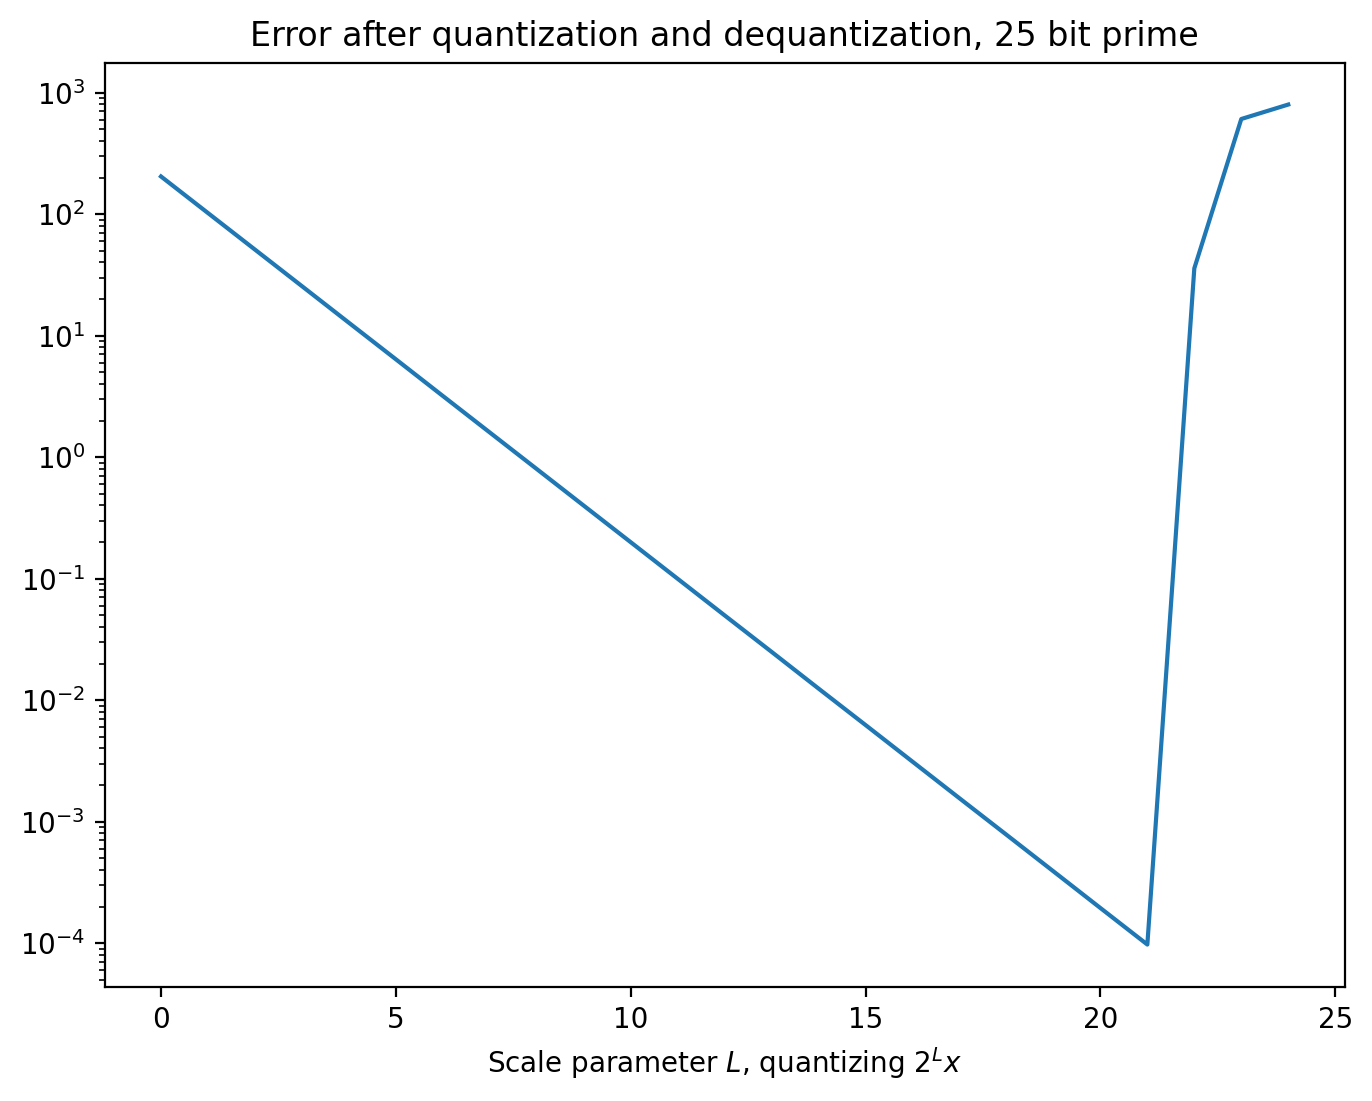

In [8]:
plt.title(f"Error after quantization and dequantization, {n_bits} bit prime")
plt.xlabel("Scale parameter $L$, quantizing $2^L x$")
plt.yscale("log")
plt.plot(n_bits_range, quantization_error)

In [9]:
def rel_err(approx, true, ord=None):
    eps = np.finfo(true.dtype).eps
    enum = np.linalg.norm(np.array(approx - true), ord=ord)
    denom = np.linalg.norm(true, ord=ord) + eps
    return enum / denom

In [35]:
X_train = np.random.randn(num_samples, num_features)
y_train = np.random.randn(num_samples, 1)

num_workers = 15
num_stragglers = 5
security_guarantee = 0
privacy_guarantee = 2
prime_number = 2**25 - 39
fit_intercept = False

precisions = np.arange(16)

rel_errors = []

for precision in precisions:

    oracle = oracles.LCCLeastSquaresOracle(
        X_train,
        y_train,
        prime_number,
        num_workers=num_workers,
        num_stragglers=num_stragglers,
        security_guarantee=security_guarantee,
        privacy_guarantee=privacy_guarantee,
        precision=precision,
        fit_intercept=fit_intercept,
    )
    true_mm = oracle.debug_matmul()
    lcc_mm = oracle.matmul()
    rel_errors.append(rel_err(lcc_mm, true_mm))

Initialized K=10 batches
Number of succedeed to restore correctly: N>=23
Initialized K=10 batches
Number of succedeed to restore correctly: N>=23
Initialized K=10 batches
Number of succedeed to restore correctly: N>=23
Initialized K=10 batches
Number of succedeed to restore correctly: N>=23
Initialized K=10 batches
Number of succedeed to restore correctly: N>=23
Initialized K=10 batches
Number of succedeed to restore correctly: N>=23
Initialized K=10 batches
Number of succedeed to restore correctly: N>=23
Initialized K=10 batches
Number of succedeed to restore correctly: N>=23
Initialized K=10 batches
Number of succedeed to restore correctly: N>=23
Initialized K=10 batches
Number of succedeed to restore correctly: N>=23
Initialized K=10 batches
Number of succedeed to restore correctly: N>=23
Initialized K=10 batches
Number of succedeed to restore correctly: N>=23
Initialized K=10 batches
Number of succedeed to restore correctly: N>=23
Initialized K=10 batches
Number of succedeed to res

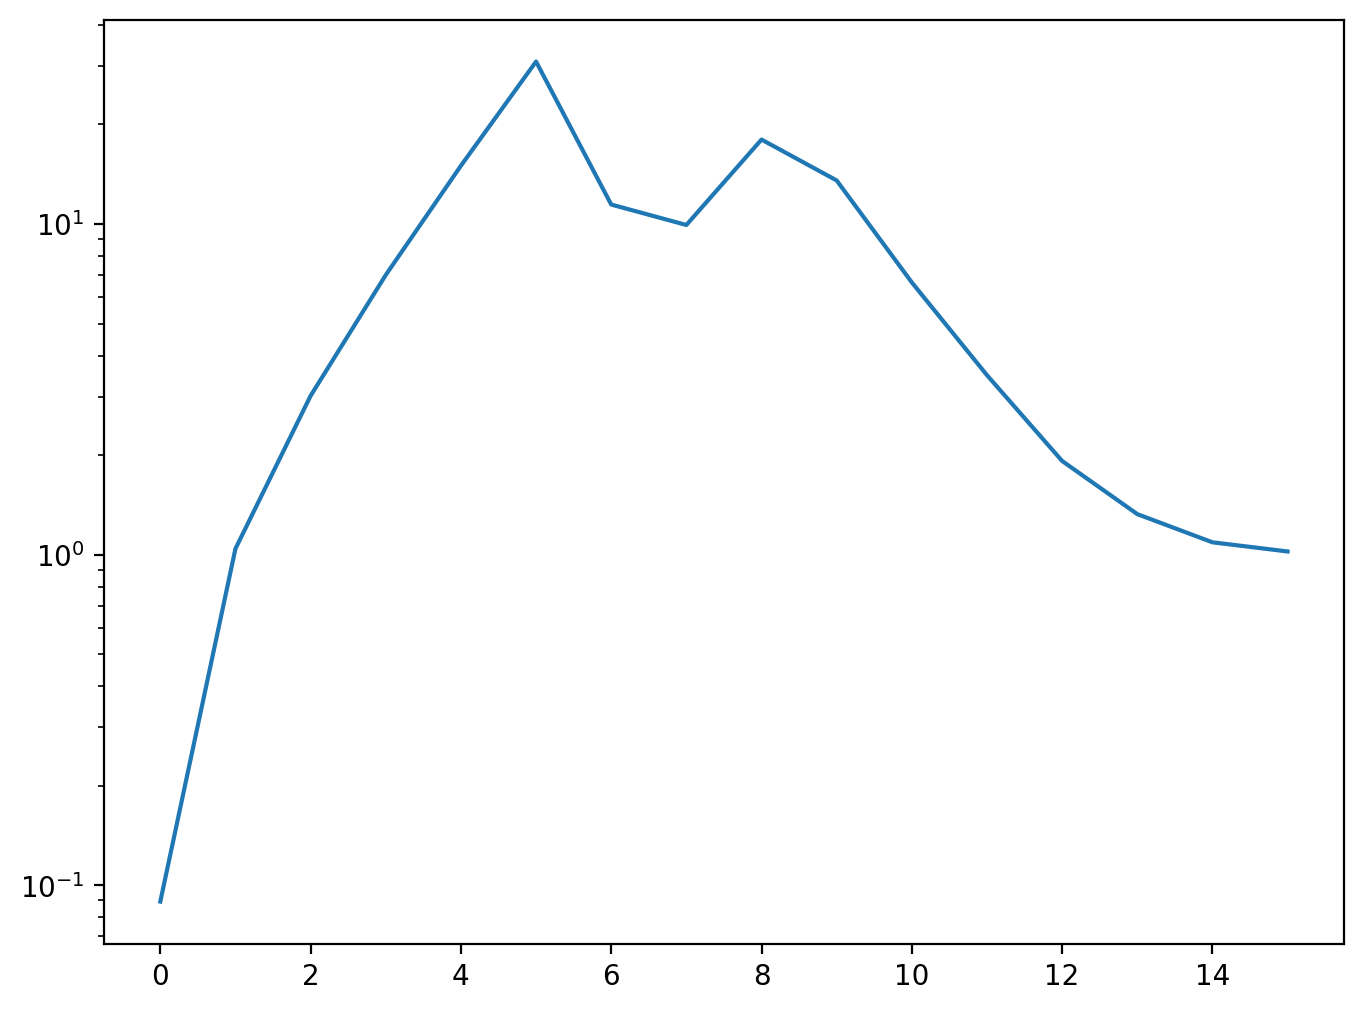

In [36]:
plt.semilogy(precisions, rel_errors)

In [11]:
start, stop, step = 500, 5000, 500
samples_range = np.arange(start, stop + step, step)
num_features = 100

prime_number = 2**25 - 39

num_workers = 30
num_stragglers = 5
security_guarantee = 0
privacy_guarantee = 2
beta = 1.15
sigmas = 10**3
precision = 0
fit_intercept = False
sigmas = [100, 1000, 10000, 100000, 1000000]

rel_errors = {"lcc": {}, "alcc": {}}
rel_errors["lcc"][0] = []
for sigma in sigmas:
    rel_errors["alcc"][sigma] = []

for num_samples in tqdm(samples_range):

    X_train = np.random.randn(num_samples, num_features)
    y_train = np.random.randn(num_samples, 1)

    oracle = oracles.LCCLeastSquaresOracle(
        X_train,
        y_train,
        prime_number,
        num_workers=num_workers,
        num_stragglers=num_stragglers,
        security_guarantee=security_guarantee,
        privacy_guarantee=privacy_guarantee,
        precision=precision,
        fit_intercept=fit_intercept,
    )
    true_mm = oracle.debug_matmul()
    lcc_mm = oracle.matmul()
    rel_errors["lcc"][0].append(rel_err(lcc_mm, true_mm))

    for sigma in sigmas:
        oracle = oracles.ALCCLeastSquaresOracle(
            X_train,
            y_train,
            num_workers=num_workers,
            num_stragglers=num_stragglers,
            security_guarantee=security_guarantee,
            privacy_guarantee=privacy_guarantee,
            beta=beta,
            sigma=sigma,
            fit_intercept=fit_intercept,
        )
        lcc_mm = oracle.matmul()
        rel_errors["alcc"][sigma].append(rel_err(lcc_mm, true_mm))

  0%|          | 0/10 [00:00<?, ?it/s]

Initialized K=10 batches
Numbers of succeded workers to restore correctly: N>=23
Initialized K=10 batches
Numbers of succeded workers to restore correctly: N>=23
Initialized K=10 batches
Numbers of succeded workers to restore correctly: N>=23
Initialized K=10 batches
Numbers of succeded workers to restore correctly: N>=23
Initialized K=10 batches
Numbers of succeded workers to restore correctly: N>=23
Initialized K=10 batches
Numbers of succeded workers to restore correctly: N>=23
Initialized K=10 batches
Numbers of succeded workers to restore correctly: N>=23
Initialized K=10 batches
Numbers of succeded workers to restore correctly: N>=23
Initialized K=10 batches
Numbers of succeded workers to restore correctly: N>=23
Initialized K=10 batches
Numbers of succeded workers to restore correctly: N>=23
Initialized K=10 batches
Numbers of succeded workers to restore correctly: N>=23
Initialized K=10 batches
Numbers of succeded workers to restore correctly: N>=23
Initialized K=10 batches
Num

In [15]:
def latex_float(f):
    float_str = "{0:.2g}".format(f)
    if "e" in float_str:
        base, exponent = float_str.split("e")
        return r"{0} \times 10^{{{1}}}".format(base, int(exponent))
    else:
        return float_str

Text(0.5, 1.0, 'Accuracy of computations over real data $X \\sim \\mathcal{N}(0, I)$')

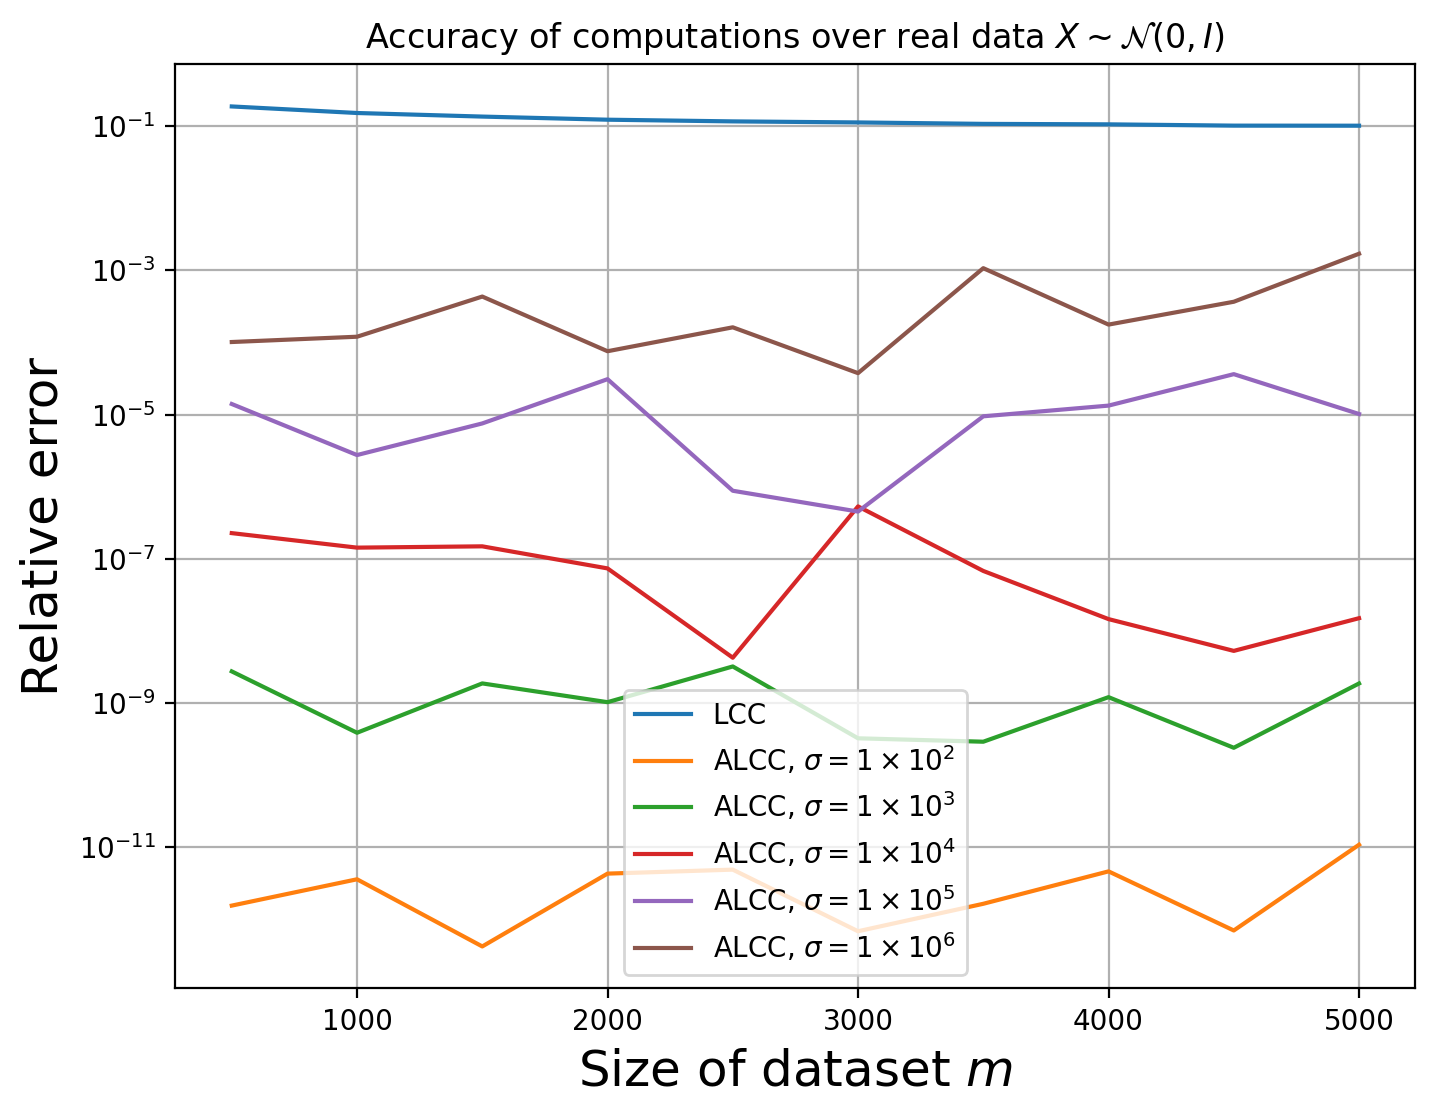

In [20]:
for name, v in rel_errors.items():
    for sigma, result in v.items():
        if name == "alcc":
            label = r"{}".format(f"{name.upper()}, $\sigma={latex_float(sigma)}$")
        else:
            label = name.upper()
        plt.plot(samples_range, result, label=label)
plt.xlabel("Size of dataset $m$", fontsize=fontsize)
plt.ylabel("Relative error", fontsize=fontsize)
plt.legend()
plt.yscale("log")
plt.grid()
plt.title("Accuracy of computations over real data $X \sim \mathcal{N}(0, I)$")

In [14]:
num_workers = 30
num_stragglers = 2
security_guarantee = 0
privacy_guarantee = 3
beta = 1.15
sigma = 100
fit_intercept = False
precision = 0

oracle = oracles.ALCCLeastSquaresOracle(
    X_train,
    y_train,
    num_workers=num_workers,
    num_stragglers=num_stragglers,
    security_guarantee=security_guarantee,
    privacy_guarantee=privacy_guarantee,
    beta=beta,
    sigma=sigma,
    fit_intercept=fit_intercept,
)

Initialized K=10 batches
Numbers of succeded workers to restore correctly: N>=25


In [20]:
rel_err(oracle.func(random_weight), oracle._debug_func(random_weight))

1.32841498276603e-14

In [22]:
rel_err(oracle.grad(random_weight), oracle._debug_grad(random_weight))

2.4653321737384944e-13

In [23]:
oracle.grad(true_weight)[:10], oracle._debug_grad(true_weight)[:10]

(array([-3.62615538e-09,  1.15232979e-09,  1.69347913e-09, -5.22049959e-10,
         1.08821041e-09,  1.84991222e-09,  2.83762347e-10,  1.19871402e-09,
        -6.78483048e-10, -2.28465069e-09]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

In [24]:
oracle.grad(random_weight)[:10].real, oracle._debug_grad(random_weight)[:10]

(array([   254.71855834,  -7747.33827752, -19005.88891083, -16857.70842555,
          5518.04228291,  -2504.92769992, -21834.98330626,  -6870.99661062,
         10419.44669591,   2386.78140044]),
 array([   254.71855834,  -7747.33827752, -19005.88891083, -16857.70842555,
          5518.04228291,  -2504.92769991, -21834.98330626,  -6870.99661062,
         10419.44669591,   2386.78140044]))

In [29]:
import liboptpy.unconstr_solvers as solvers
import liboptpy.step_size as ss

In [30]:
import matplotlib as mpl
import sys

mpl.rcParams.update(mpl.rcParamsDefault)
sys.path.append("/Library/TeX/texbin/latex")
plt.rc("text", usetex=True)

In [114]:
max_iter = 500
tol = 1e-12
L = np.linalg.norm(oracle.X) ** 2 / 4
step_size = 1 / L
# optim = solvers.fo.AcceleratedGD(oracle._debug_func, oracle._debug_grad, ss.Backtracking(rule_type="Lipschitz", rho=0.5, eps=1e-2, init_alpha=0.5))
optim = solvers.fo.AcceleratedGD(
    oracle._debug_func, oracle._debug_grad, ss.ConstantStepSize(step_size)
)
w0 = np.ones(num_features)
w_opt = optim.solve(w0, max_iter, tol, disp=True)
optim.convergence.append(w_opt)
f_vals = [oracle._debug_func(w) for w in optim.convergence]
grad_vals = [np.linalg.norm(oracle._debug_grad(w)) ** 2 for w in optim.convergence]

Maximum iteration exceeds!
Convergence in 500 iterations
Function value = 2.361351963293628e-21
Norm of gradient = 5.914427899639055e-09


In [278]:
num_workers = 30
num_stragglers = 5
security_guarantee = 0
privacy_guarantee = 3
beta = 1.1
sigmas = [100, 1000, 10000, 100000, 1000000]
fit_intercept = False

coded_grad_vals = {}
for sigma in sigmas:
    oracle = ALCCLeastSquaresOracle(
        X_train,
        y_train,
        num_workers=num_workers,
        num_stragglers=num_stragglers,
        security_guarantee=security_guarantee,
        privacy_guarantee=privacy_guarantee,
        beta=beta,
        sigma=sigma,
        fit_intercept=fit_intercept,
    )
    max_iter = 500
    tol = 1e-12
    optim = solvers.fo.AcceleratedGD(
        oracle.func, oracle.grad, ss.ConstantStepSize(step_size)
    )
    w0 = np.ones(num_features)
    w_opt = optim.solve(w0, max_iter, tol, disp=True)
    optim.convergence.append(w_opt)
    coded_grad_vals[sigma] = [
        np.linalg.norm(oracle._debug_grad(w)) ** 2 for w in optim.convergence
    ]

Initialized K=10 batches
Numbers of succeded workers to restore correctly: N>=25
Maximum iteration exceeds!
Convergence in 500 iterations
Function value = 4.0122561133740824e-19
Norm of gradient = 1.0462060723286108e-07
Initialized K=10 batches
Numbers of succeded workers to restore correctly: N>=25
Maximum iteration exceeds!
Convergence in 500 iterations
Function value = 4.248198167151473e-15
Norm of gradient = 8.5121593294116e-06
Initialized K=10 batches
Numbers of succeded workers to restore correctly: N>=25


KeyboardInterrupt: 

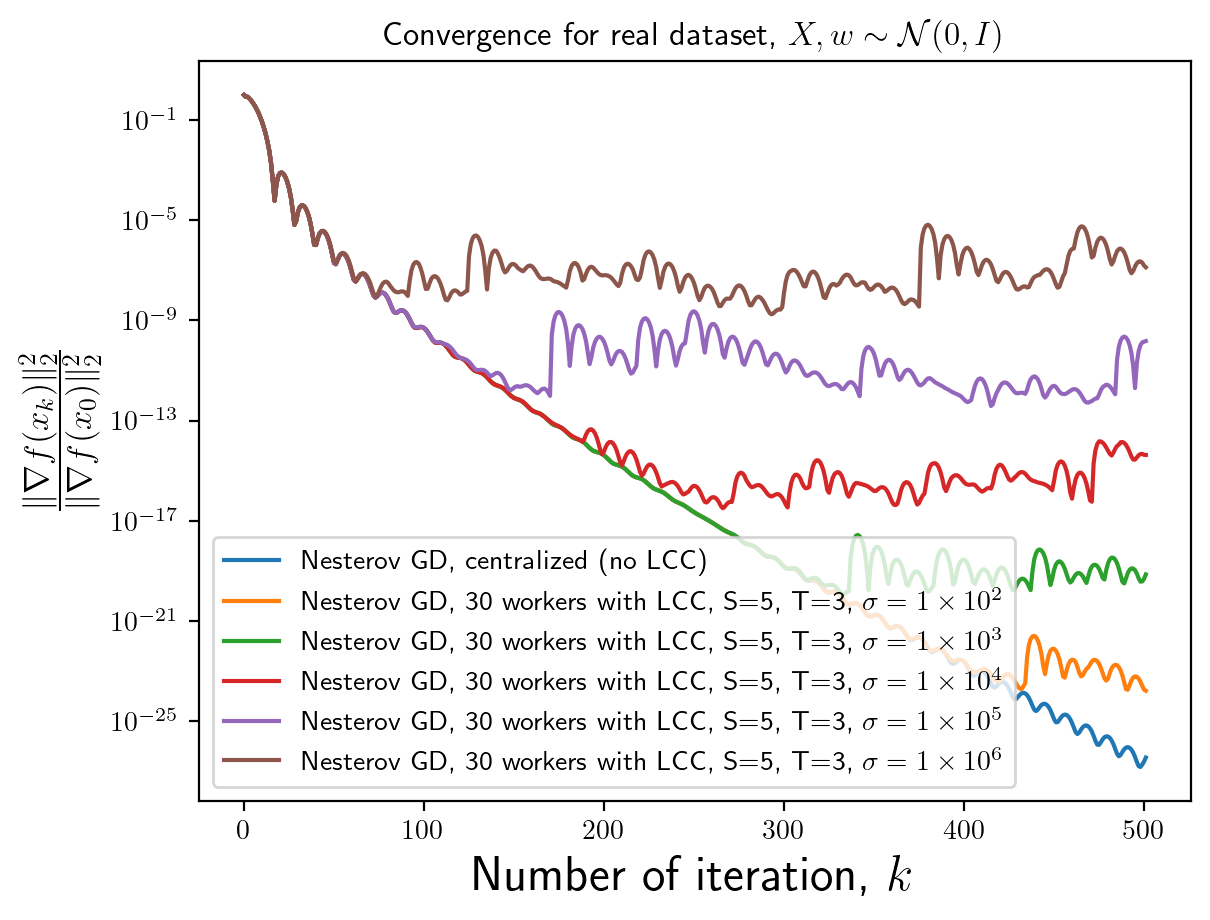

In [222]:
plt.title(r"Convergence for real dataset, $X, w \sim \mathcal{N}(0, I)$")
plt.xlabel(r"Number of iteration, $k$", fontsize=fontsize)
plt.ylabel(
    r"$\frac{\| \nabla f(x_k)\|^2_2}{\| \nabla f(x_0)\|^2_2}$", fontsize=fontsize
)
plt.plot(grad_vals / grad_vals[0], label="Nesterov GD, centralized (no LCC)")

for sigma in sigmas:
    coded_grad = coded_grad_vals[sigma]
    plt.plot(
        coded_grad / coded_grad[0],
        label=r"{}".format(
            f"Nesterov GD, 30 workers with LCC, S={oracle.num_stragglers}, T={oracle.privacy_guarantee}, $\sigma={latex_float(sigma)}$"
        ),
    )
# plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.savefig("lcc_int.pdf")
plt.show()

In [279]:
num_workers = 30
num_stragglers = 5
security_guarantee = 0
privacy_guarantee = 3
betas = [1.01, 1.05, 1.1, 1.25, 1.75]
# sigmas = [10, 100, 1000, 10000]
sigma = "adaptive"
fit_intercept = False

coded_grad_vals = {}
for beta in betas:
    oracle = ALCCLeastSquaresOracle(
        X_train,
        y_train,
        num_workers=num_workers,
        num_stragglers=num_stragglers,
        security_guarantee=security_guarantee,
        privacy_guarantee=privacy_guarantee,
        beta=beta,
        sigma=sigma,
        fit_intercept=fit_intercept,
    )
    max_iter = 500
    tol = 1e-12
    optim = solvers.fo.AcceleratedGD(
        oracle.func, oracle.grad, ss.ConstantStepSize(step_size)
    )
    w0 = np.ones(num_features)
    w_opt = optim.solve(w0, max_iter, tol, disp=True)
    optim.convergence.append(w_opt)
    coded_grad_vals[beta] = [
        np.linalg.norm(oracle._debug_grad(w)) ** 2 for w in optim.convergence
    ]

Initialized K=10 batches
Numbers of succeded workers to restore correctly: N>=25
Maximum iteration exceeds!
Convergence in 500 iterations
Function value = 2.3789971500918256e-21
Norm of gradient = 5.961662280846264e-09
Initialized K=10 batches
Numbers of succeded workers to restore correctly: N>=25
Maximum iteration exceeds!
Convergence in 500 iterations
Function value = 2.3697970134512678e-21
Norm of gradient = 5.942068785683139e-09
Initialized K=10 batches
Numbers of succeded workers to restore correctly: N>=25
Maximum iteration exceeds!
Convergence in 500 iterations
Function value = 2.3544351051941187e-21
Norm of gradient = 5.906511969562635e-09
Initialized K=10 batches
Numbers of succeded workers to restore correctly: N>=25
Maximum iteration exceeds!
Convergence in 500 iterations
Function value = 2.77915606582721e-21
Norm of gradient = 6.02441988253401e-09
Initialized K=10 batches
Numbers of succeded workers to restore correctly: N>=25
Maximum iteration exceeds!
Convergence in 500 

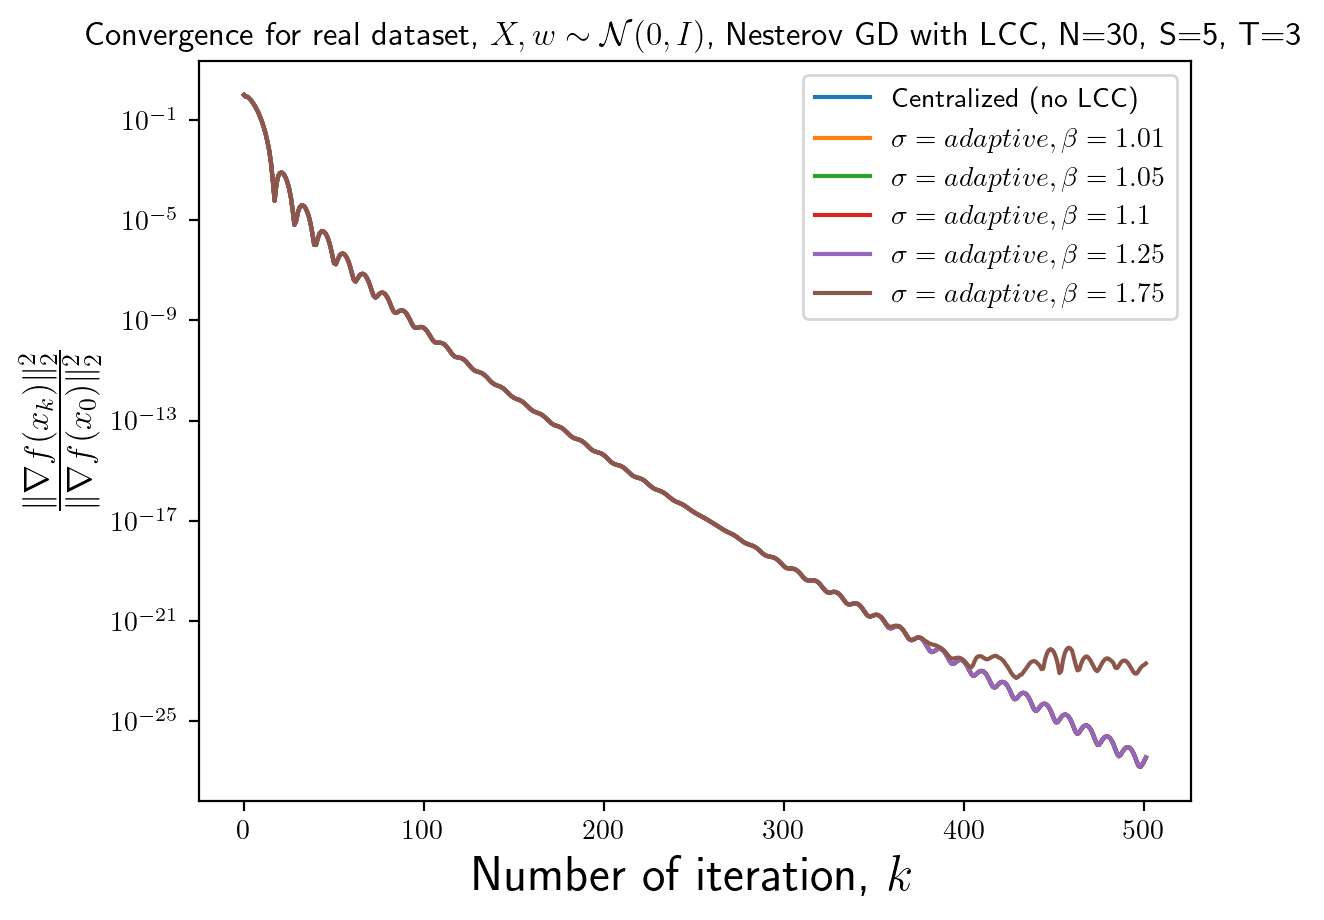

In [291]:
plt.title(
    r"{}".format(
        "Convergence for real dataset, $X, w \sim \mathcal{N}(0, I)$, "
        + f"Nesterov GD with LCC, N={oracle.num_workers}, S={oracle.num_stragglers}, T={oracle.privacy_guarantee}"
    )
)
plt.xlabel(r"Number of iteration, $k$", fontsize=fontsize)
plt.ylabel(
    r"$\frac{\| \nabla f(x_k)\|^2_2}{\| \nabla f(x_0)\|^2_2}$", fontsize=fontsize
)
plt.plot(grad_vals / grad_vals[0], label="Centralized (no LCC)")

for beta in betas:
    coded_grad = coded_grad_vals[beta]
    plt.plot(
        coded_grad / coded_grad[0],
        label=r"{}".format(f"$\sigma={sigma}, \\beta={beta}$"),
    )
# plt.xscale("log")
plt.yscale("log")
plt.legend()
# plt.savefig("lcc_real.pdf")
plt.show()

In [163]:
bits_float = np.array(bits, dtype="float64")

In [ ]:
num_workers = 30
num_stragglers = 5
security_guarantee = 0
privacy_guarantee = 3
betas = 1 + np.logspace(-3, 0, 4)
sigmas = [10, 100, 1000, 10000]
fit_intercept = False

coded_grad_vals = {}
for sigma in sigmas:
    oracle = ALCCLeastSquaresOracle(
        X_train,
        y_train,
        num_workers=num_workers,
        num_stragglers=num_stragglers,
        security_guarantee=security_guarantee,
        privacy_guarantee=privacy_guarantee,
        beta=beta,
        sigma=sigma,
        fit_intercept=fit_intercept,
    )
    max_iter = 500
    tol = 1e-12
    optim = solvers.fo.AcceleratedGD(
        oracle.func, oracle.grad, ss.ConstantStepSize(step_size)
    )
    w0 = np.ones(num_features)
    w_opt = optim.solve(w0, max_iter, tol, disp=True)
    optim.convergence.append(w_opt)
    coded_grad_vals[sigma] = [
        np.linalg.norm(oracle._debug_grad(w)) ** 2 for w in optim.convergence
    ]

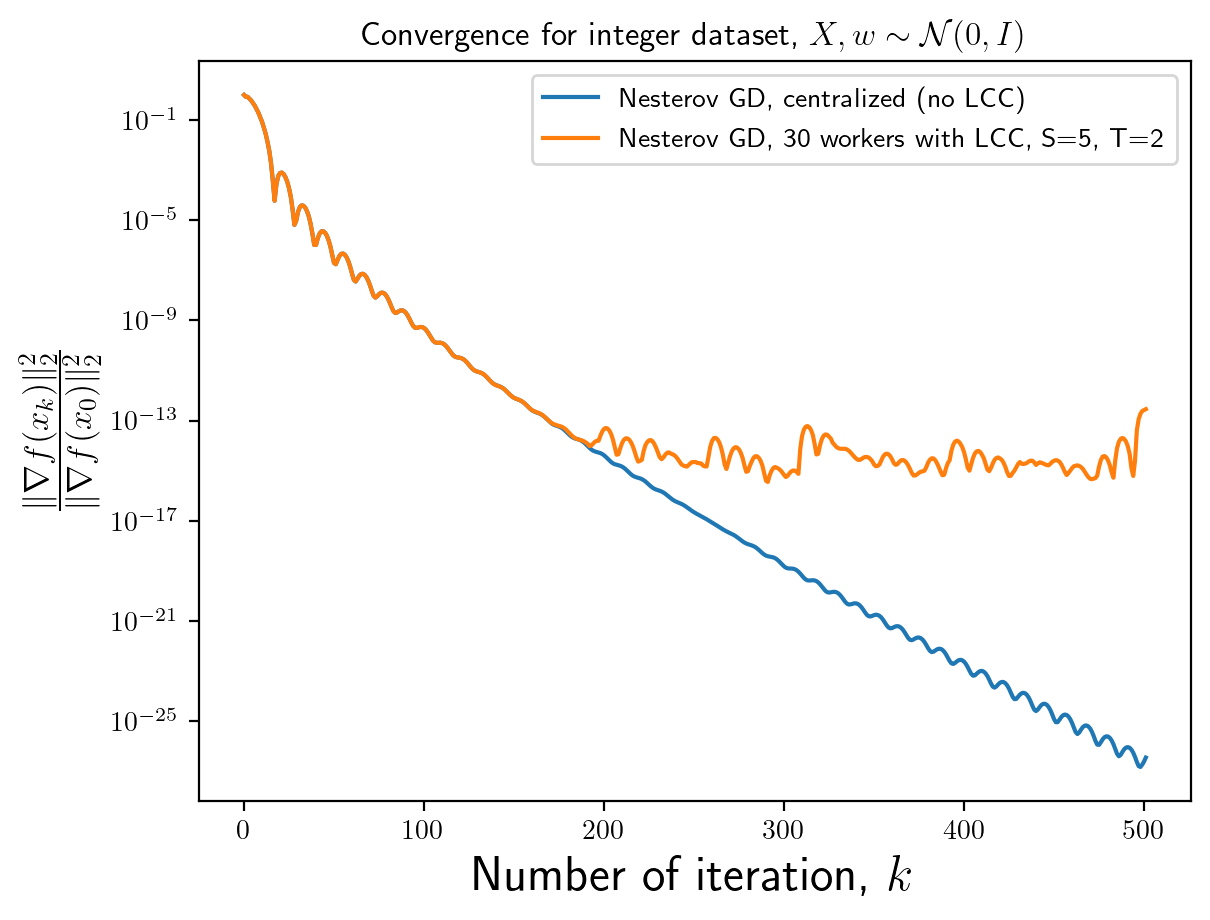

In [139]:
plt.title(r"Convergence for integer dataset, $X, w \sim \mathcal{N}(0, I)$")
plt.xlabel("Number of iteration, $k$", fontsize=fontsize)
plt.ylabel(
    r"$\frac{\| \nabla f(x_k)\|^2_2}{\| \nabla f(x_0)\|^2_2}$", fontsize=fontsize
)
plt.plot(grad_vals / grad_vals[0], label="Nesterov GD, centralized (no LCC)")
plt.plot(
    coded_grad_vals / coded_grad_vals[0],
    label=f"Nesterov GD, 30 workers with ALCC, S={oracle.num_stragglers}, T={oracle.privacy_guarantee}, sigma={}",
)
# plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.savefig("lcc_int.pdf")
plt.show()

In [3]:
def compare_costs(degrees, n_computations, T=1, A=1):
    total_computations = n_computations.sum()
    costs = {}
    costs["Scheme 0"] = (
        total_computations,
        degrees.max() * (total_computations + T - 1) + 2 * A + 1,
    )
    costs["Schemes I-II"] = (
        total_computations,
        (degrees * (n_computations + T - 1) + 2 * A + 1).sum(),
    )
    costs["Scheme III"] = (
        total_computations,
        (degrees * (n_computations + T - 1) + total_computations - n_computations).max()
        + 2 * A
        + 1,
    )
    return costs

In [4]:
n_polynomials = 50
degrees = 2 ** (1 + np.arange(n_polynomials))
n_computations = 1 + np.arange(n_polynomials)
compare_costs(degrees, n_computations)

{'Scheme 0': (1275, 1435522381224345603),
 'Schemes I-II': (1275, 110338190870577304),
 'Scheme III': (1275, 56294995342132428)}

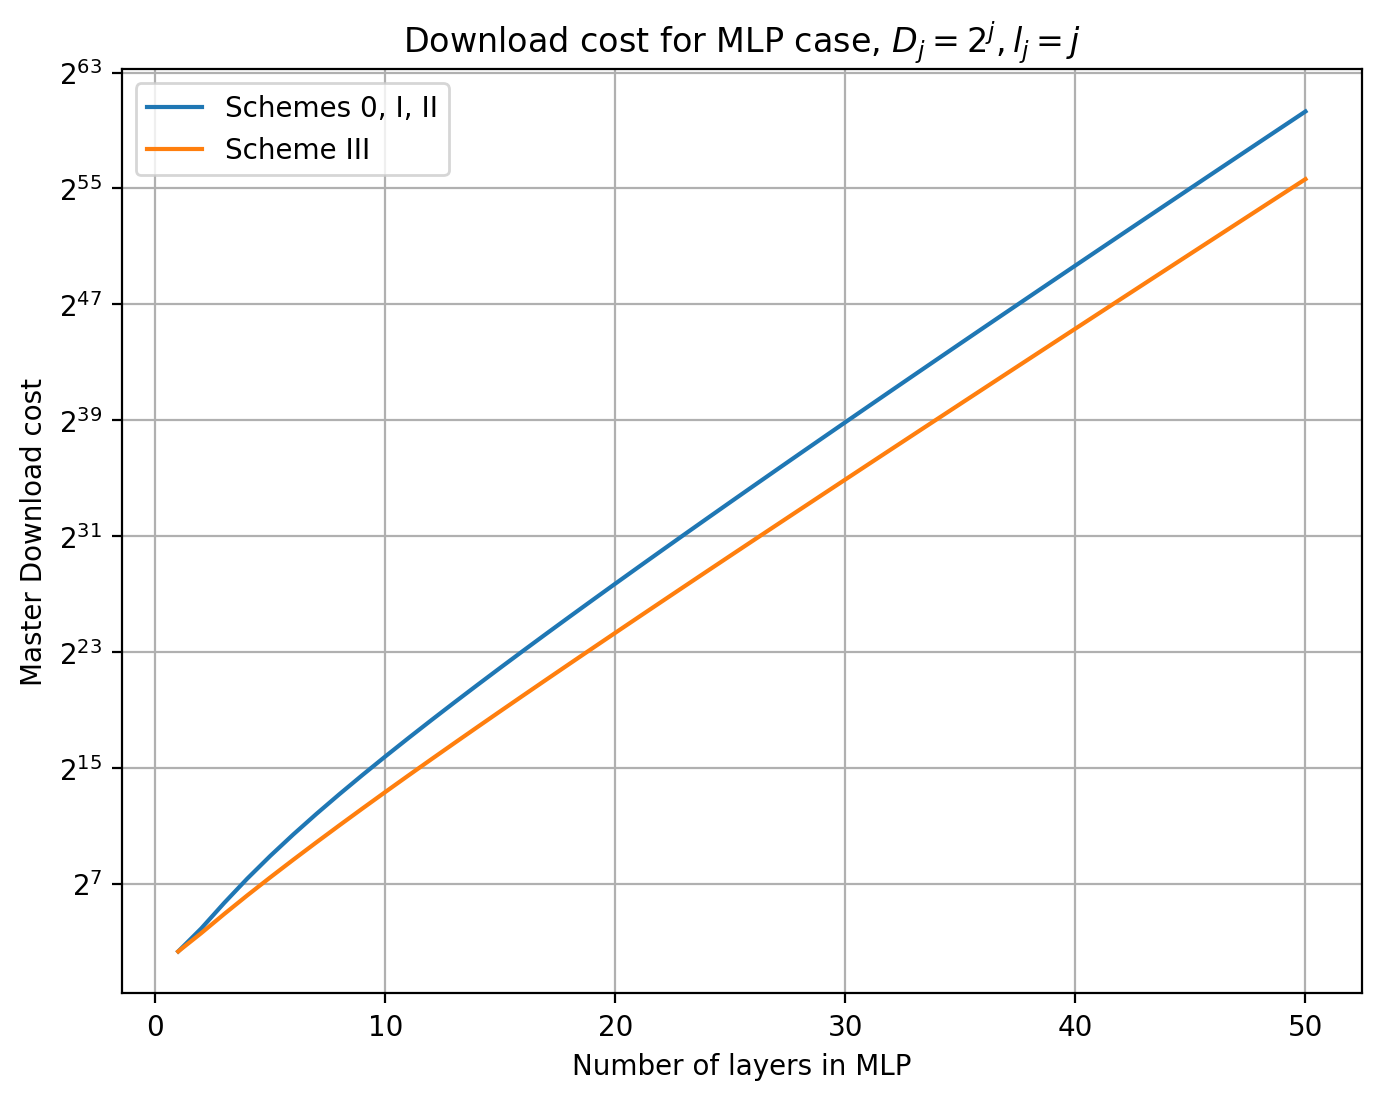

In [9]:
L_range = 1 + np.arange(50)
all_costs = {k: [] for k in ["Scheme 0", "Schemes I-II", "Scheme III"]}
for n_polynomials in L_range:
    degrees = 2**n_polynomials
    n_computations = 1 + np.arange(n_polynomials)
    new_costs = compare_costs(degrees, n_computations)
    [all_costs[scheme].append(new_costs[scheme]) for scheme in new_costs.keys()]
for scheme, costs in all_costs.items():
    if scheme != "Schemes I-II":
        if scheme == "Scheme 0":
            scheme = "Schemes 0, I, II"
        costs = np.array(costs)
        plt.plot(L_range, costs[:, 1], label=scheme)
plt.xlabel("Number of layers in MLP")
plt.ylabel("Master Download cost")
plt.title("Download cost for MLP case, $D_j=2^j, l_j=j$")
plt.grid()
# plt.xscale("log")
plt.yscale("log", base=2)
plt.legend()

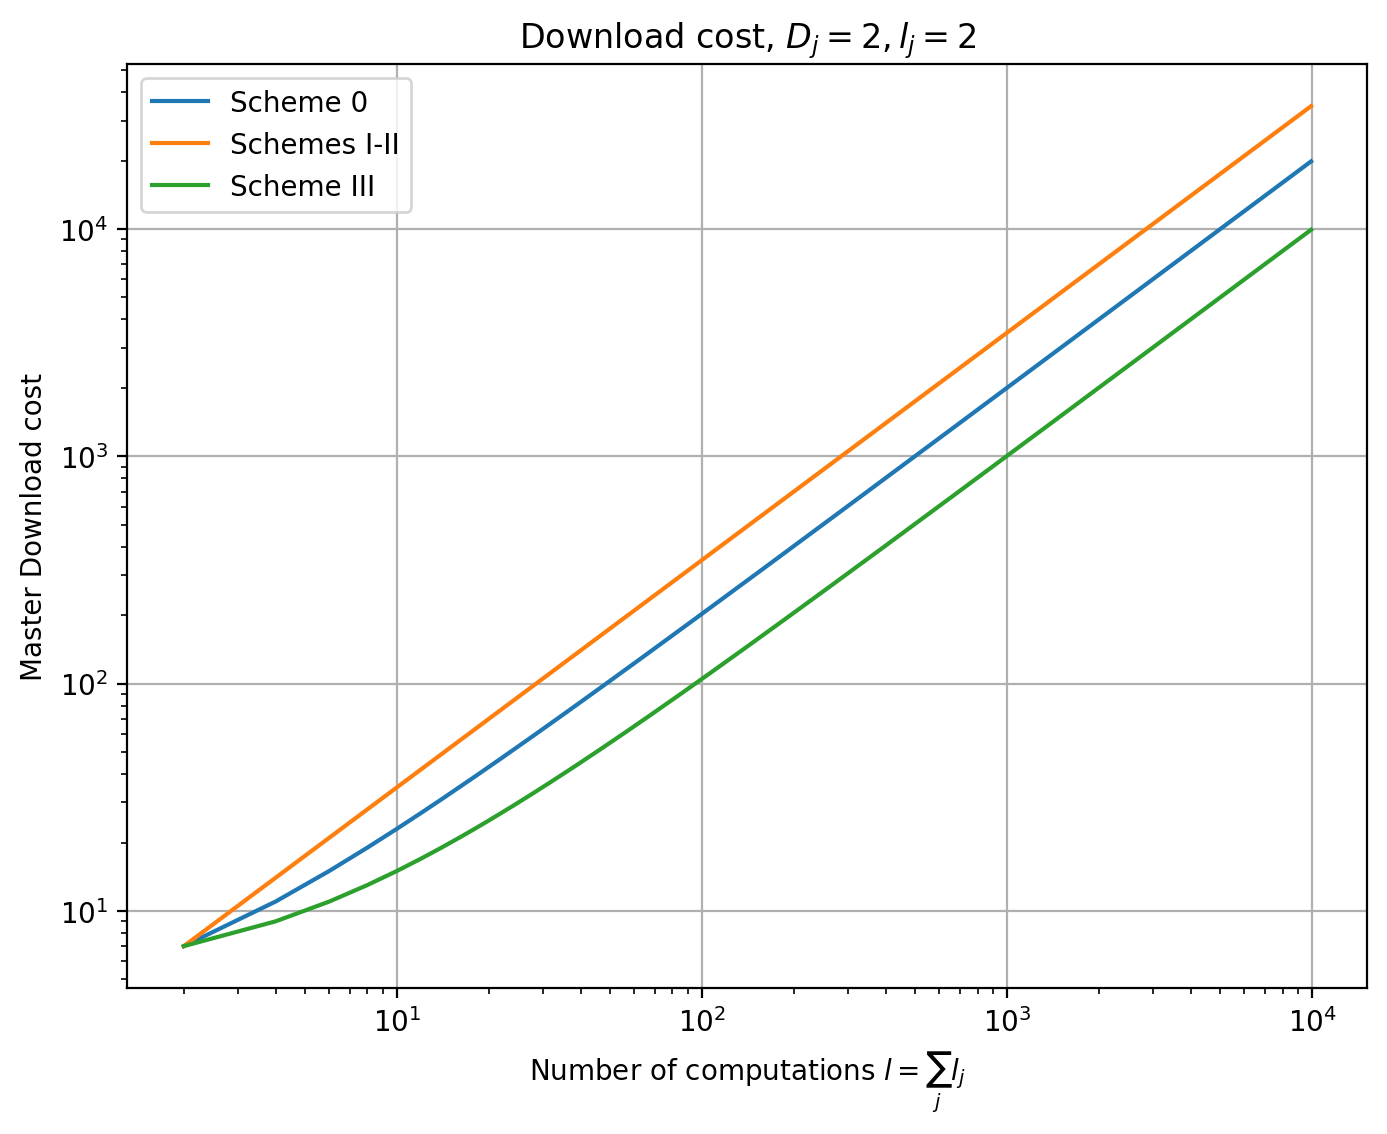

In [129]:
L_range = np.unique(np.logspace(0, 4, 1000).astype(int))
all_costs = {k: [] for k in ["Scheme 0", "Schemes I-II", "Scheme III"]}
for n_polynomials in L_range:
    degrees = 2 * np.ones(n_polynomials)
    n_computations = 2 * np.ones(n_polynomials)
    if n_computations.sum() > 1e4:
        break
    new_costs = compare_costs(degrees, n_computations)
    [all_costs[scheme].append(new_costs[scheme]) for scheme in new_costs.keys()]
for scheme, costs in all_costs.items():
    costs = np.array(costs)
    plt.plot(costs[:, 0], costs[:, 1], label=scheme)
plt.xlabel("Number of computations $l=\sum_j l_j$")
plt.ylabel("Master Download cost")
plt.title("Download cost, $D_j=2, l_j=2$")
plt.grid()
plt.xscale("log")
plt.yscale("log")
plt.legend()

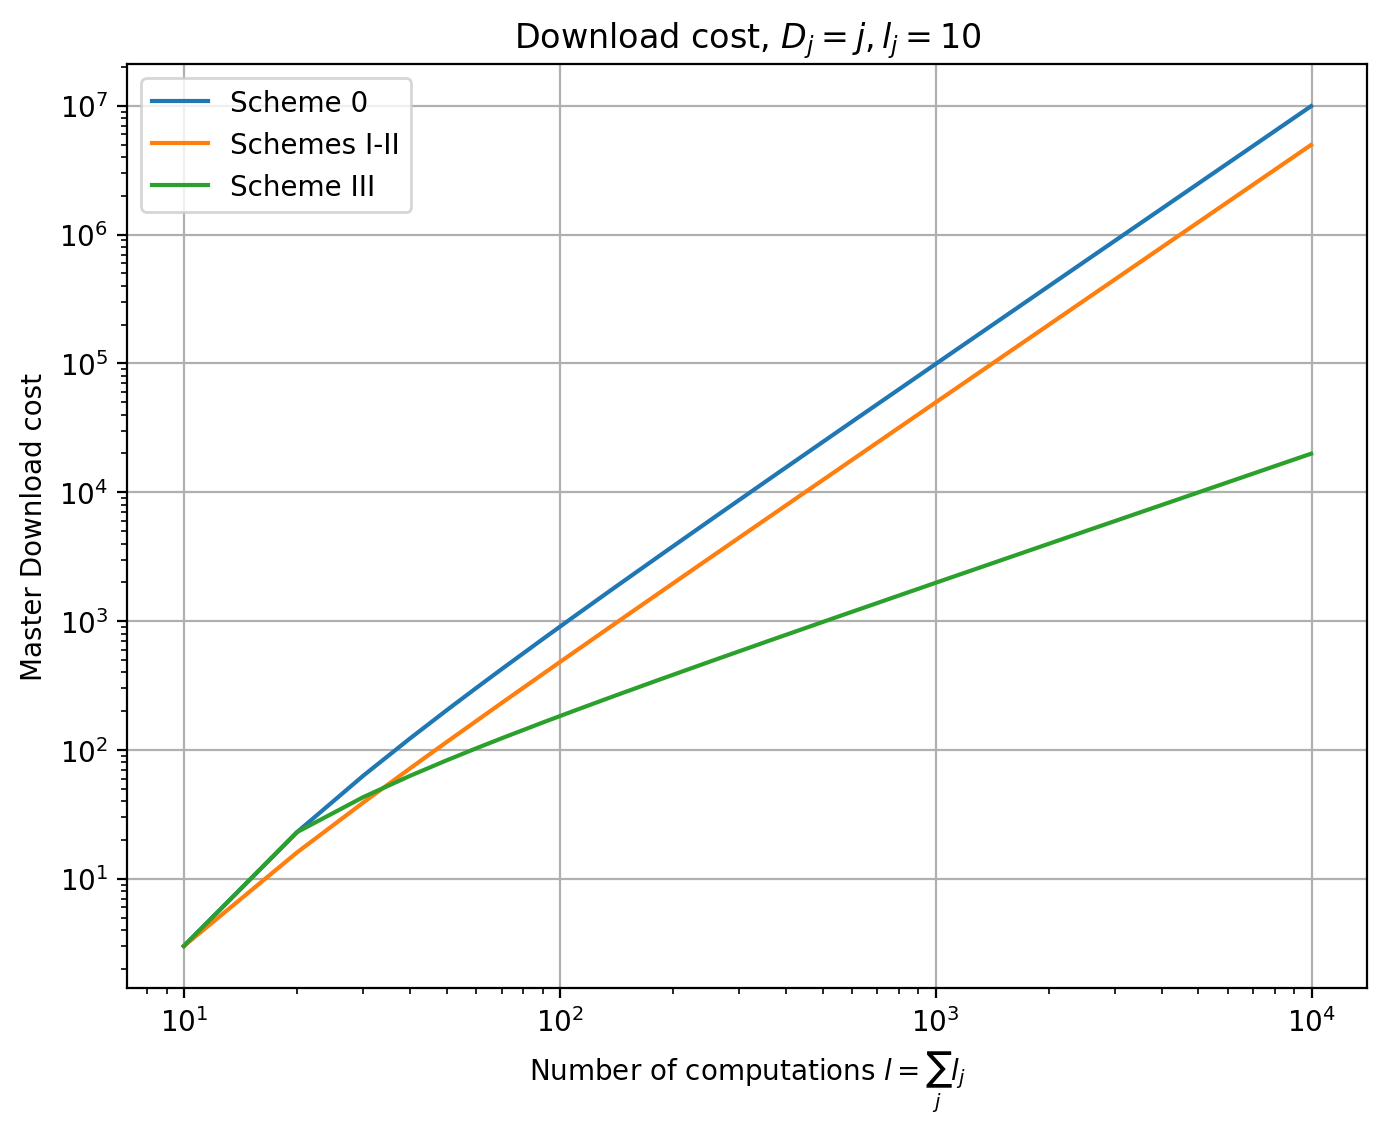

In [130]:
L_range = np.unique(np.logspace(0, 4, 1000).astype(int))
all_costs = {k: [] for k in ["Scheme 0", "Schemes I-II", "Scheme III"]}
for n_polynomials in L_range:
    degrees = np.arange(n_polynomials)
    n_computations = 10 * np.ones(n_polynomials)
    if n_computations.sum() > 1e4:
        break
    new_costs = compare_costs(degrees, n_computations)
    [all_costs[scheme].append(new_costs[scheme]) for scheme in new_costs.keys()]
for scheme, costs in all_costs.items():
    costs = np.array(costs)
    plt.plot(costs[:, 0], costs[:, 1], label=scheme)
plt.xlabel("Number of computations $l=\sum_j l_j$")
plt.ylabel("Master Download cost")
plt.title("Download cost, $D_j=j, l_j=10$")
plt.grid()
plt.xscale("log")
plt.yscale("log")
plt.legend()

In [132]:
all_costs

{'Scheme 0': [(1000.0, 10003.0),
  (2000.0, 20003.0),
  (3000.0, 30003.0),
  (4000.0, 40003.0),
  (5000.0, 50003.0),
  (6000.0, 60003.0),
  (7000.0, 70003.0),
  (8000.0, 80003.0),
  (9000.0, 90003.0),
  (10000.0, 100003.0)],
 'Schemes I-II': [(1000.0, 10003.0),
  (2000.0, 20006.0),
  (3000.0, 30009.0),
  (4000.0, 40012.0),
  (5000.0, 50015.0),
  (6000.0, 60018.0),
  (7000.0, 70021.0),
  (8000.0, 80024.0),
  (9000.0, 90027.0),
  (10000.0, 100030.0)],
 'Scheme III': [(1000.0, 10003.0),
  (2000.0, 11003.0),
  (3000.0, 12003.0),
  (4000.0, 13003.0),
  (5000.0, 14003.0),
  (6000.0, 15003.0),
  (7000.0, 16003.0),
  (8000.0, 17003.0),
  (9000.0, 18003.0),
  (10000.0, 19003.0)]}

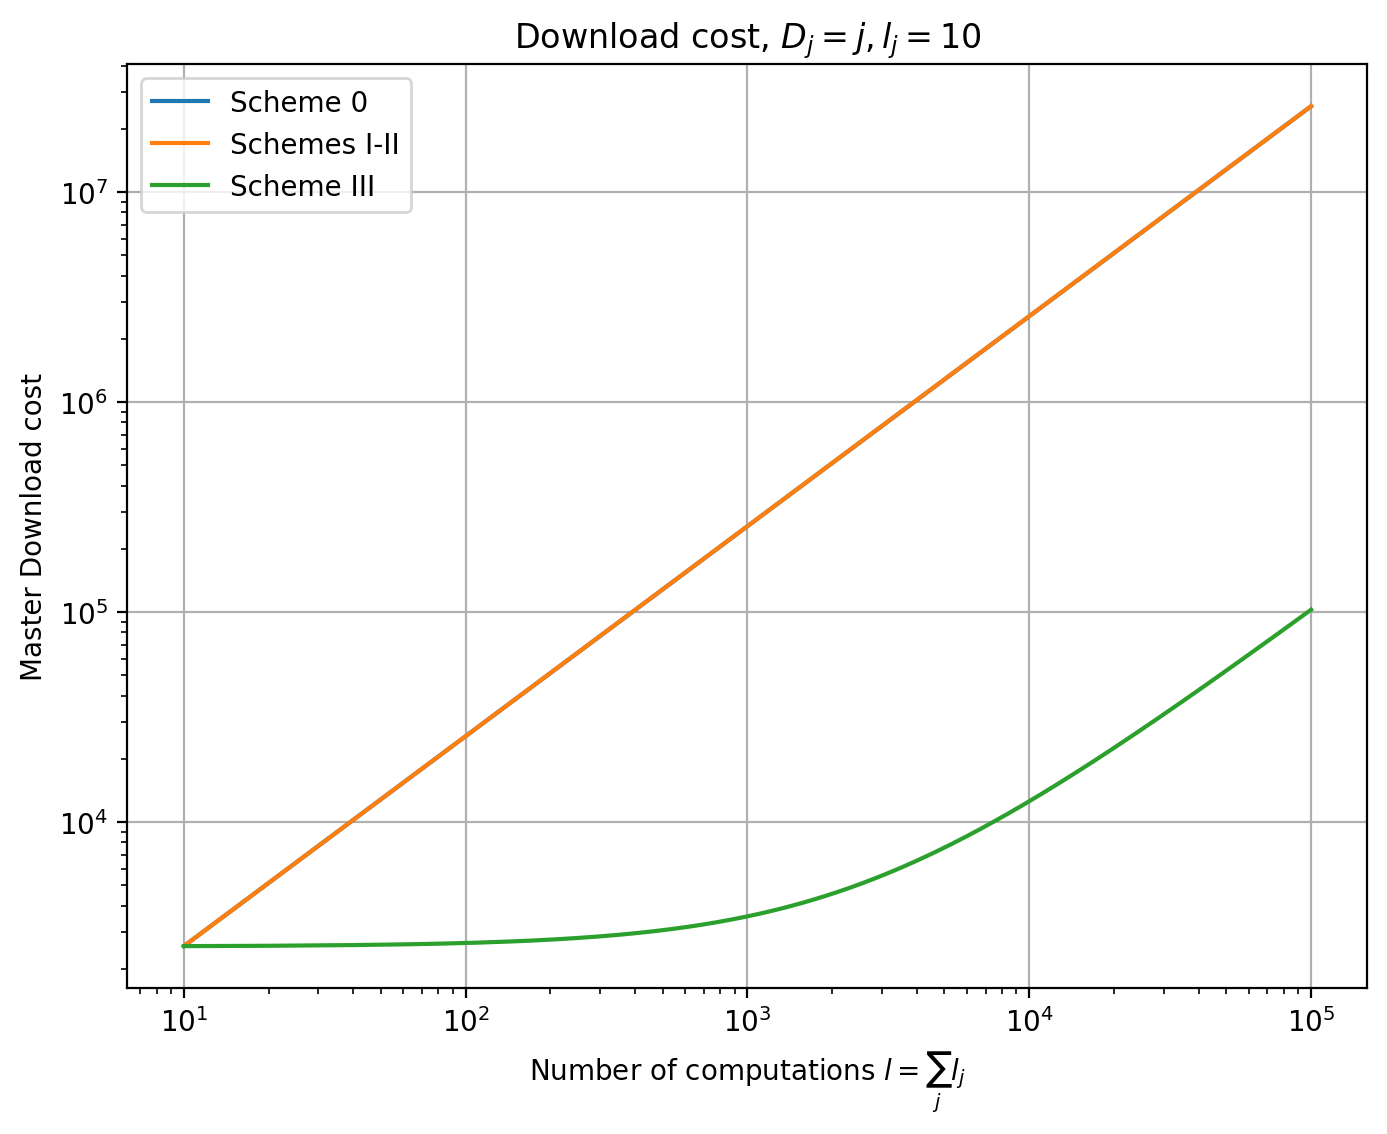

In [146]:
L_range = np.unique(np.logspace(0, 4, 1000).astype(int))
all_costs = {k: [] for k in ["Scheme 0", "Schemes I-II", "Scheme III"]}
for n_polynomials in L_range:
    degrees = 256 * np.ones(n_polynomials)
    n_computations = 10 * np.ones(n_polynomials)
    new_costs = compare_costs(degrees, n_computations)
    [all_costs[scheme].append(new_costs[scheme]) for scheme in new_costs.keys()]
for scheme, costs in all_costs.items():
    costs = np.array(costs)
    plt.plot(costs[:, 0], costs[:, 1], label=scheme)
plt.xlabel("Number of computations $l=\sum_j l_j$")
plt.ylabel("Master Download cost")
plt.title("Download cost, $D_j=j, l_j=10$")
plt.grid()
plt.xscale("log")
plt.yscale("log")
plt.legend()

In [135]:
all_costs

{'Scheme 0': [(1000.0, 10003.0),
  (2000.0, 20003.0),
  (3000.0, 30003.0),
  (4000.0, 40003.0),
  (5000.0, 50003.0),
  (6000.0, 60003.0),
  (7000.0, 70003.0),
  (8000.0, 80003.0),
  (9000.0, 90003.0),
  (10000.0, 100003.0),
  (11000.0, 110003.0),
  (12000.0, 120003.0),
  (13000.0, 130003.0),
  (14000.0, 140003.0),
  (15000.0, 150003.0),
  (16000.0, 160003.0),
  (17000.0, 170003.0),
  (18000.0, 180003.0),
  (19000.0, 190003.0),
  (20000.0, 200003.0),
  (21000.0, 210003.0),
  (22000.0, 220003.0),
  (23000.0, 230003.0),
  (24000.0, 240003.0),
  (25000.0, 250003.0),
  (26000.0, 260003.0),
  (27000.0, 270003.0),
  (28000.0, 280003.0),
  (29000.0, 290003.0),
  (30000.0, 300003.0),
  (31000.0, 310003.0),
  (32000.0, 320003.0),
  (33000.0, 330003.0),
  (34000.0, 340003.0),
  (35000.0, 350003.0),
  (36000.0, 360003.0),
  (37000.0, 370003.0),
  (38000.0, 380003.0),
  (39000.0, 390003.0),
  (40000.0, 400003.0),
  (41000.0, 410003.0),
  (42000.0, 420003.0),
  (43000.0, 430003.0),
  (44000.0, 44000